# Ball and Stick

*(Behrens et al. 2003)* proposed to represent the intra-axonal diffusion as a Stick - a cylinder with zero radius - and the extra-axonal diffusion as a Ball - an isotropic Gaussian compartment.

\begin{equation}
 E^{\textrm{Ball and}}_{\textrm{Sticks}}=\underbrace{f_h\overbrace{E_{iso}(\lambda_{\textrm{iso}})}^{\textrm{Ball}}}_{\textrm{Extra-Axonal}}+ \sum_{i=1}^{N}\underbrace{f_{i,r}\overbrace{E_r(\boldsymbol{\mu}_i|\lambda_\parallel)}^{\textrm{Stick}}}_{\textrm{Intra-Axonal}}
\end{equation}

For this first example, we will restrict ourselves to the case where $N$=1

# Human Connectome Project Example

In [1]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


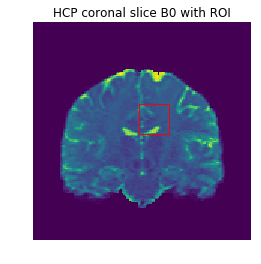

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
rect = patches.Rectangle((70,70),20,20,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

## Generate Ball and Stick model

In [3]:
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
BAS_mod = MultiCompartmentModel(models=[stick, ball])

Visualize the model:

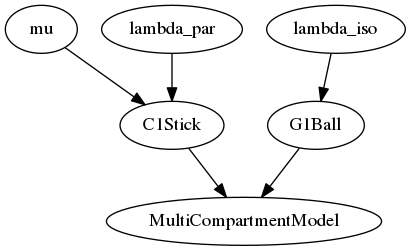

In [4]:
from IPython.display import Image
BAS_mod.visualize_model_setup(view=False, cleanup=False, with_parameters=True)
Image('Model Setup.png')

## Fit Ball and Stick model to HCP data
Having numba and pathos installed, fitting the model to a coronal slice takes about a minute:

In [5]:
BAS_fit_hcp = BAS_mod.fit(scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.816338062286 seconds
Fitting of 8181 voxels complete in 74.6848318577 seconds.
Average of 0.00912905902184 seconds per voxel.


## Visualize results

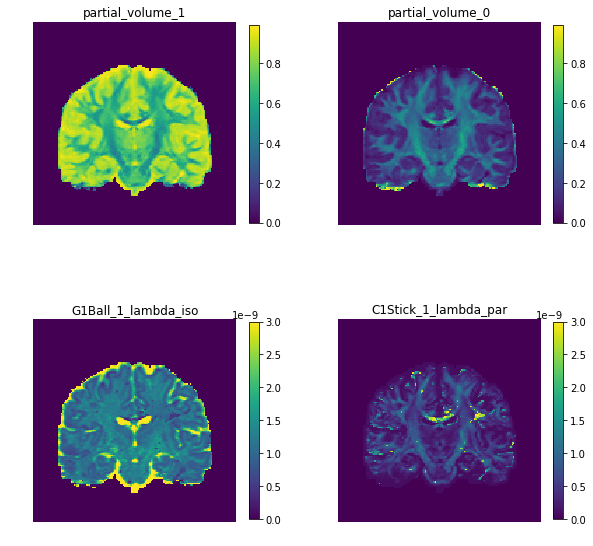

In [6]:
fitted_parameters = BAS_fit_hcp.fitted_parameters

fig, axs = plt.subplots(2, 2, figsize=[10, 10])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.8)
    counter += 1

Notice that using this very simple model we get some familiar maps, where the Ball model takes the role of extra-axonal and CSF compartments, and the stick takes the intra-axonal compartment. 

Also notice that the maps are not completely smooth (especially lambda_par) as optimization can still fall in a local minima despite the brute force optimization. 

## Fixing Parameters during optimization

Model parameters are often fixed to a static value to force certain model behaviour. For instance, often parallel diffusivity is fixed to $\lambda_\parallel=1.7e-9m^2/s$. In Dmipy, fixing parameters can be easily done by using the model.fit_parameter(parameter_name, value) function.

In [7]:
BAS_mod.set_fixed_parameter('C1Stick_1_lambda_par', 1.7e-9)

# then just proceed as before
BAS_fit_hcp_fixed = BAS_mod.fit(
    scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)

fitted_parameters_fixed = BAS_fit_hcp_fixed.fitted_parameters

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 0.0931029319763 seconds
Fitting of 8181 voxels complete in 57.9014000893 seconds.
Average of 0.00707754554324 seconds per voxel.


Notice that fitting was now also twice as fast since lambda_par is now not optimized.

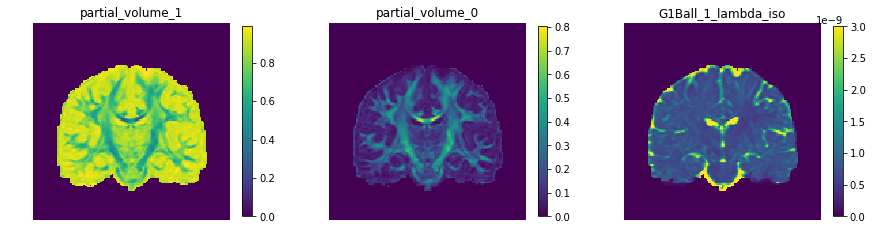

In [8]:
fig, axs = plt.subplots(1, 3, figsize=[15, 5])
axs = axs.ravel()

counter = 0
for name, values in fitted_parameters_fixed.items():
    if values.squeeze().ndim != 2:
        continue
    cf = axs[counter].imshow(values.squeeze().T, origin=True, interpolation='nearest')
    axs[counter].set_title(name)
    axs[counter].set_axis_off()
    fig.colorbar(cf, ax=axs[counter], shrink=0.7)
    counter += 1

Notice that nose lambda_par is always set to 1.7e-9, and the other parameters are now optimized while using that constraint. See that lambda_iso and partial_volume are now completely smooth, but will be biased if the parallel diffusivity is not 1.7e-9 in reality.

## Visualizing estimated peak orientations

We visualize the stick orientations (peaks) on the right side of the corpus callosum and use the estimated stick volume fraction as background.

In [9]:
from dipy.viz import fvtk
from dipy.viz.actor import slicer
import numpy as np
affine = np.eye(4)
affine[0,3] = -10
affine[1,3] = -10

volume = BAS_fit_hcp_fixed.fitted_parameters['partial_volume_0']
volume_im = slicer(volume[70:90,0, 70:90, None], interpolation='nearest', affine=affine, opacity=0.7)

ren = fvtk.ren()
peaks = BAS_fit_hcp_fixed.peaks_cartesian()[70:90, :, 70:90]
peaks_intensities = volume[70:90, :, 70:90, None]
peaks_fvtk = fvtk.peaks(peaks, peaks_intensities, scale=1.)
peaks_fvtk.RotateX(90)
peaks_fvtk.RotateZ(180)
peaks_fvtk.RotateY(180)
fvtk.add(ren, peaks_fvtk)
fvtk.add(ren, volume_im)
fvtk.record(ren=ren, size=[700, 700], out_path='dipy.png')

/user/rfick/home/anaconda2/lib/python2.7/site-packages/vtk/util/numpy_support.py:134: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


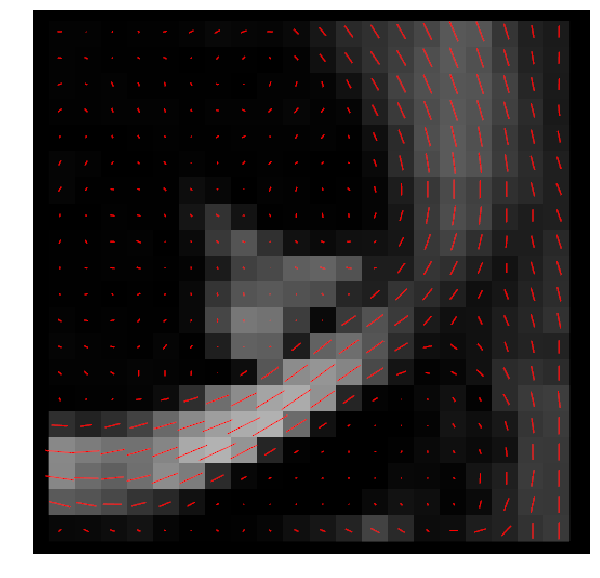

In [10]:
import matplotlib.image as mpimg
img = mpimg.imread('dipy.png')
plt.figure(figsize=[10, 10])
plt.imshow(img[100:-97, 100:-85])
plt.axis('off');

You can see the corpus callosum coming in the from the left and joining the centrum semiovale on the right. The intensity of the background shows volume fraction of the stick, which is also used to scale the size of the peak. Notice the estimated volume fraction is high in the corpus callosum and lower in non-white matter areas. Also notice that Ball and Stick with one compartment cannot estimate crossings, which are expected in the centrum semiovale on the right. Using multiple compartments to model crossings is explored in the Microstructure in Crossings examples.

## Estimating Error Metrics: MSE and $R^2$

Whenever you fit a model, it's always wise to check out the error of the model fit. Here we estimate the Mean Squared Error (MSE) and the $R^2$ coefficient of determination. In MSE the lower is better, while $R^2$ has an upper bound of one, which represents a perfect model fit.

/user/rfick/home/anaconda2/lib/python2.7/site-packages/dmipy-0.1.dev0-py2.7.egg/dmipy/core/fitted_modeling_framework.py:211: RuntimeWarning: invalid value encountered in divide
/user/rfick/home/anaconda2/lib/python2.7/site-packages/dmipy-0.1.dev0-py2.7.egg/dmipy/core/fitted_modeling_framework.py:198: RuntimeWarning: invalid value encountered in divide


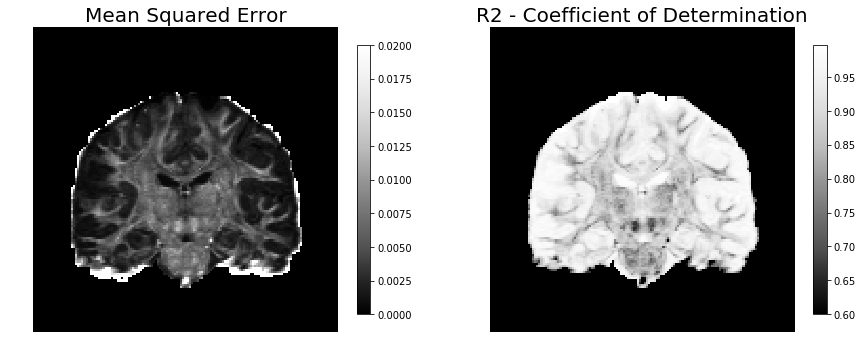

In [11]:
mse = BAS_fit_hcp_fixed.mean_squared_error(data_hcp)
R2 = BAS_fit_hcp_fixed.R2_coefficient_of_determination(data_hcp)

fig, axs = plt.subplots(1, 2, figsize=[15, 15])
cf = axs[0].imshow(mse.squeeze().T, origin=True, vmax=0.02, cmap='Greys_r')
fig.colorbar(cf, ax=axs[0], shrink=0.33)
axs[0].set_title('Mean Squared Error', fontsize=20)
axs[0].set_axis_off()
cf = axs[1].imshow(R2.squeeze().T, origin=True, vmin=0.6, cmap='Greys_r')
fig.colorbar(cf, ax=axs[1], shrink=0.33)
axs[1].set_title('R2 - Coefficient of Determination', fontsize=20);
axs[1].set_axis_off()

Ideally, you want the MSE and $R^2$ to show no structure of the underlying data - which would mean the model can at least fit the data equally well everywhere. Instead, in Ball and Stick we can see clearly see the structure of the different brain areas. This means that Ball and Stick model cannot fit the diffusion equally well in all brian areas, and that interpretation of model parameters will be biased when comparing them between these different areas.

When doing these studies, ALWAYS verify whether differences in estimated parameters reflect actual tissue changes, or only reflect the limitations of the model itself.

## References
- Behrens, Timothy EJ, et al. "Characterization and propagation of uncertainty in diffusion‐weighted MR imaging." Magnetic resonance in medicine 50.5 (2003): 1077-1088.